<a href="https://colab.research.google.com/github/AishwaryaAshok846/Heart-Disease-Prediction/blob/main/heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease Prediction Using Machine Learning

### Project Overview

Cardiovascular diseases (CVDs) are the leading cause of death globally, accounting for approximately 31% of all deaths worldwide. Early detection of heart disease is crucial, as many cases can be managed or prevented through timely medical intervention.

In this project, we analyze a heart disease dataset containing clinical and demographic information of patients. The goal is to build and evaluate machine learning models that can predict whether a patient is likely to have heart disease based on these features.

This notebook follows a structured data science workflow:
- Data loading and inspection  
- Exploratory Data Analysis (EDA)  
- Data preprocessing  
- Model training and evaluation  
- Model comparison and insights  

This project is for educational purposes only and does not serve as a medical diagnosis tool.


## Dataset Description

This dataset was obtained from Kaggle and was originally compiled by combining
multiple heart disease datasets from the UCI Machine Learning Repository.

It contains clinical and demographic features that are commonly used in heart
disease risk assessment, along with a binary target variable indicating the
presence or absence of heart disease.


In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# Style
# sns.set(style="whitegrid")


## Data Loading

Loading the heart disease dataset and exploring its structure, size, and basic characteristics.

In [10]:
df = pd.read_csv('/content/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [17]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

#check for duplicate values
print("\nDuplicate values: ")
print(df.duplicated().sum())

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Duplicate values: 
0


### Dataset Summary

- The dataset contains **918 patient records** and **12 columns**
- There are **no missing values** in any feature
- Features include both **numerical** and **categorical** variables
- The target variable is **HeartDisease** which is in binary
- No duplicate rows exist in the database


Target Variable distribution

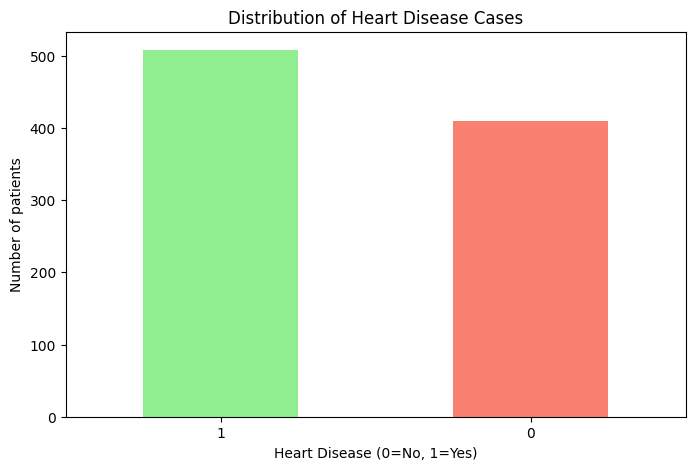


Percentage with heart disease: 55.3%


In [21]:
# Distribution of target variable (heart disease presence)
target = df['HeartDisease'].value_counts()

plt.figure(figsize=(8, 5))
target.plot(kind='bar', color=['lightgreen', 'salmon'])
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Number of patients')
plt.xticks(rotation=0)
plt.show()

disease_count = target[1]
total_patients = len(df)

disease_perc = (disease_count / total_patients) * 100
disease_perc = round(disease_perc, 1)

print(f"\nPercentage with heart disease: {disease_perc}%")

**Analysis:**  
The dataset shows that 55.3% of patients have heart disease while 44.7% are healthy. This relatively balanced distribution is favorable for training machine learning models without significant class imbalance issues.